In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

In [2]:
with open("inverted_index.pkl", "rb") as file:
    inverted_index = pickle.load(file)

Так как даже очень частотные слова не встречаются в корпусе каждый день, график встречаемости слов, построенный с учётом каждого дня, был бы слишком рваным и не дал бы нужной информации. Необходимо выполнить сглаживание -- например, считать вхождения не для каждого дня, а для каждого месяца.

In [3]:
# Функция, получающая на вход список дат и возвращающая список длиной n,
# где n -- количество месяцев от start_date до end_date,
# в котором i-тое значение -- количество вхождений слова за i-тый месяц.
# Так как объект timedelta не имеет атрибута months (только days, seconds и microseconds),
# индекс каждого месяца придётся считать вручную.
def smoothing(word):
    dates = inverted_index[word]
    new_dates = [0 for i in range(228)]
    # между 01.01.2000 и 01.01.2019 всего прошло 19 * 12 = 228 месяцев.
    for date in dates:
        index = 12 * (date.year - 2000) + date.month - 1
        # Считаем индекс текущего месяца
        # если январь 2000 года имеет индекс 0, а декабрь 2018 -- 227.
        new_dates[index] += 1
    return (new_dates)

In [4]:
def daterange_months(start_date):
    # вспомогательная функция, упрощающая итерацию по месяцам
    for n in range(228):
        yield start_date + relativedelta(months=n)

In [5]:
# список всех месяцев от января 2000 года до декабря 2019 года
dates = [date for date in daterange_months(date(2000, 1, 1))]
formatter = DateFormatter('%m/%Y')

# функция, строящая график встречаемости слова.
def plot_by_month(word):
    x = smoothing(word)
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.plot(dates, x)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_title(word)
    plt.show()

In [7]:
# Попробуем построить график встречаемости случайного достаточно частотного слова.
word = random.choice(list(inverted_index.keys()))
print(f"{word}: {inverted_index[word]}")

cервис: [datetime.date(2005, 6, 15), datetime.date(2006, 4, 11), datetime.date(2006, 8, 9), datetime.date(2006, 12, 21), datetime.date(2010, 8, 17), datetime.date(2010, 11, 1), datetime.date(2011, 2, 28), datetime.date(2011, 3, 14), datetime.date(2011, 11, 22), datetime.date(2013, 10, 25), datetime.date(2013, 12, 10), datetime.date(2014, 10, 4), datetime.date(2014, 10, 28), datetime.date(2015, 3, 16), datetime.date(2015, 4, 2), datetime.date(2015, 8, 26), datetime.date(2015, 10, 27), datetime.date(2015, 12, 2), datetime.date(2015, 12, 2), datetime.date(2015, 12, 10), datetime.date(2015, 12, 11), datetime.date(2015, 12, 17), datetime.date(2017, 4, 12), datetime.date(2018, 1, 23)]


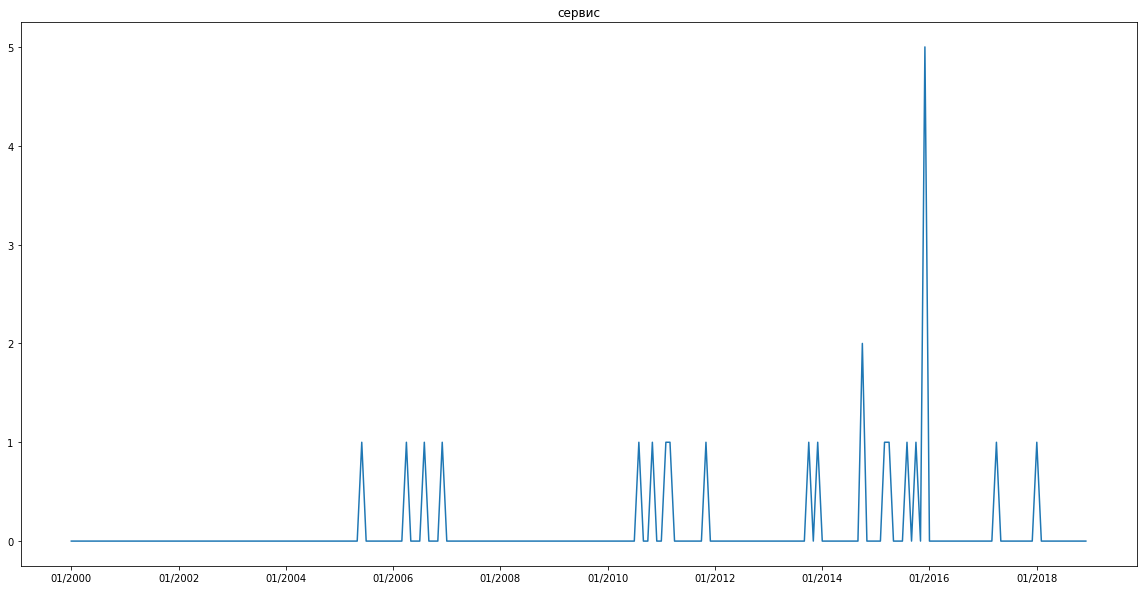

In [8]:
plot_by_month(word)
# график всё ещё рваный, но уже меньше
# применить методы сглаживания, имеющиеся в библиотеке scipy,
# не позволяло то, что по оси x лежат даты в формате datetime.date

Теперь попытаемся автоматически обнаружить появление и исчезновение того или иного слова. Исключим слова, у которых < 5 вхождений. Посчитаем среднее число вхождений за месяц для каждого слова. Будем считать стартовым и конечным месяцем слова первый и последний соответственно месяц, число вхождений в котором >= 0.25 от среднего числа вхождений.

In [11]:
# вспомогательная функция, возвращающая дату по индексу
def index_to_date(index):
    return (date(2000 + index // 12, 1 + index % 12, 1))

def start(word):
    occurences = smoothing(word)
    mean = np.mean(occurences)
    for i in range(228):
        if occurences[i] >= 0.25 * mean:
            return (index_to_date(i))

def end(word):
    occurences = smoothing(word)
    mean = np.mean(occurences)
    for i in range(227, -1, -1):
        if occurences[i] >= 0.25 * mean:
            return (index_to_date(i))

In [12]:
start(word)

datetime.date(2005, 6, 1)

In [13]:
end(word)

datetime.date(2018, 1, 1)

Как мы видим в примере выше, слово "сервис" впервые зафиксировано достаточно поздно (в 2005 году), но не исчезло из употребления в 2018 году, что не позволяет считать его словом с короткой историей. Будем считать словами с короткой историей слова, год появления которого >= 2001, а год исчезновения <= 2017.